In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# data
zenith = 'z20'  # 'random'
table = 'regressor_5sgm_exp30m_z20_xy_flip.pickle'
path = f'/home/dipiano/E4/irf_{zenith}/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))


print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS'])
DS dataset size: 20000


In [2]:
from astroai.tools.utils import split_regression_dataset

binning = 200
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, binning=binning)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(16000, 200, 200) (16000, 2)
Train dataset: 16000, (16000, 200, 200, 1)
Train labels: 16000, (16000, 2)

Test dataset: 4000, (4000, 200, 200, 1)
Test labels: 4000, (4000, 2)


In [3]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(test_data)))
# find seed to get the original heatmap
seed = len(train_data) + idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
12178,crab_18179,18179,0,100,100,318.065829,-22.780921,318.961908,-23.183047,0.917741,North_z20_N_0.5h_LST,2.5,6.069501


# Load model and weights

In [4]:
import tensorflow as tf

savename = 'regressor_FINAL_5sgm_filter6_4convs_z20_xy_flip' 
model = tf.keras.models.load_model(f'../models/cnn_regressor/{savename}.keras')
model.summary()

2024-04-04 16:45:33.091990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 16:45:33.226792: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-04 16:45:33.226821: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-04 16:45:41.998581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 6)       102       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 12)        300       
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 12)        588       
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 12)        588       
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 12)        588       
                                                        

In [5]:
%time
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 84.9 µs
125/125 [==============================] - 6s 42ms/step


(array([128.7766 , 106.07201], dtype=float32),
 array([126.83563664, 106.7095648 ]))

In [6]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# LABEL
label_pix = test_labels[idx][0] * binning, test_labels[idx][1] * binning
sky = w.pixel_to_world(label_pix[0], label_pix[1])
label_sky = sky.ra.deg, sky.dec.deg

# PREDICTION
pred_pix = predictions[idx]
sky = w.pixel_to_world(pred_pix[0], pred_pix[1])
pred_sky = sky.ra.deg, sky.dec.deg


print(f'SEED: {seed}')
print('---- PIX')
print(f"true: {true_pix}")
print(f"label: {label_pix}")
print(f"prediction: {pred_pix}")
print('---- SKY')
print(f"true: {true_sky} ")
print(f"label: {label_sky}")
print(f"prediction: {pred_sky}")

SEED: 19785
---- PIX
true: (array(126.83563664), array(106.7095648))
label: (126.83563664360223, 106.70956480220823)
prediction: [128.7766  106.07201]
---- SKY
true: (340.29047888283674, 82.86751130860833) 
label: (340.29047888283674, 82.86751130860834)
prediction: (339.9150423778824, 82.84679168174516)


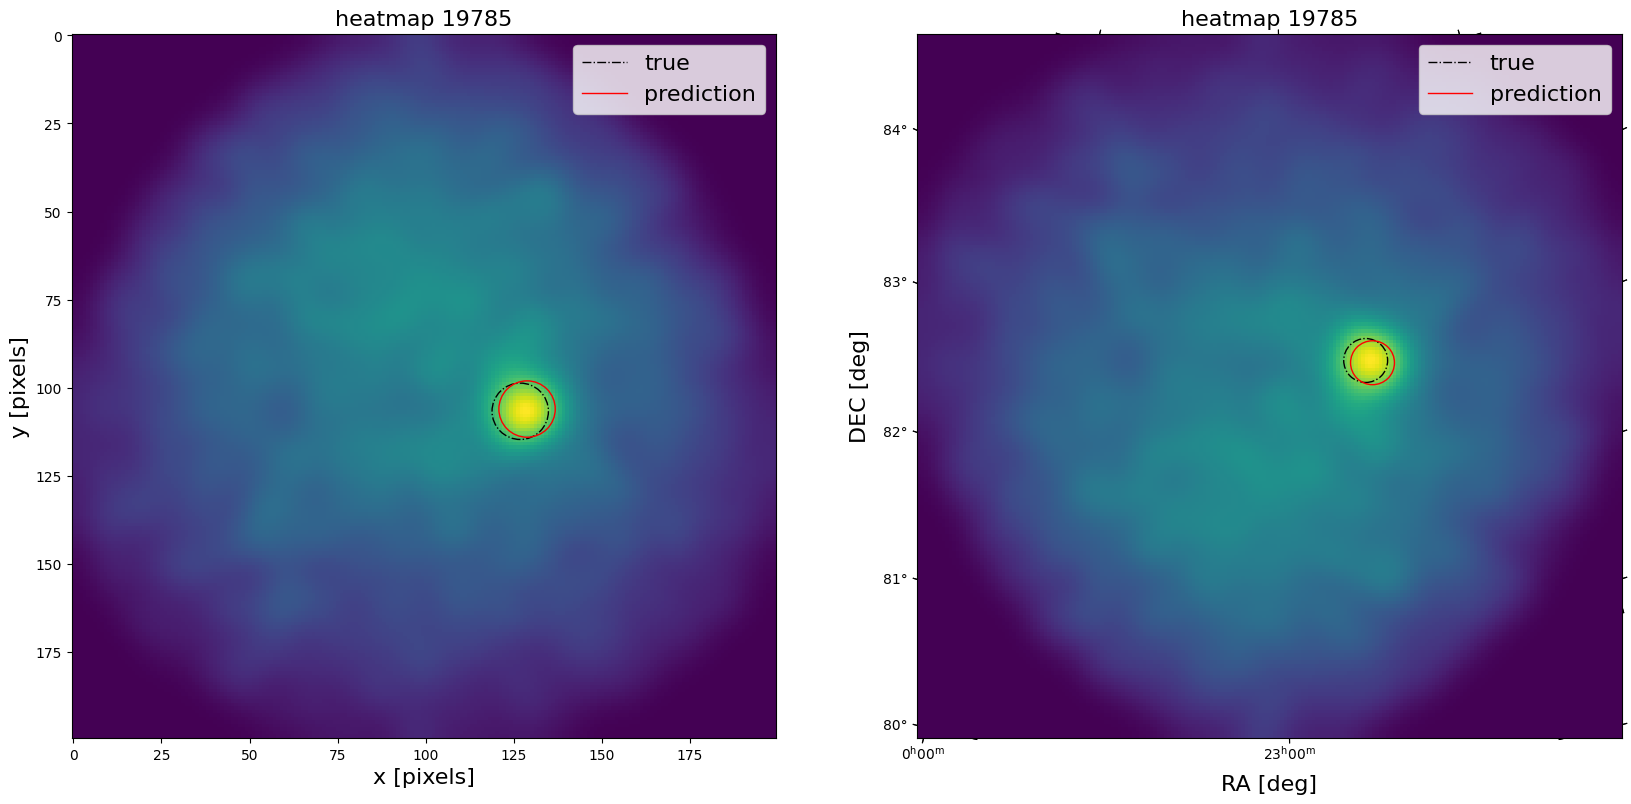

In [7]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (20, 20)
fs = 16

# PLOT
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(121), fig.add_subplot(122, projection=w)

# PIX
ax[0].imshow(test_data[idx], vmin=0, vmax=1)
ax[0].add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax[0].add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax[0].set_ylabel('y [pixels]', fontsize=fs)
ax[0].set_xlabel('x [pixels]', fontsize=fs)
ax[0].set_title(f'heatmap {seed}', fontsize=fs)

# SKY
ax[1].imshow(test_data[idx], vmin=0, vmax=1)
ax[1].scatter(true_sky[0], true_sky[1], transform=ax[1].get_transform('icrs'), s=1e3,
              edgecolor='k', facecolor='none', ls='-.')
ax[1].scatter(pred_sky[0], pred_sky[1], transform=ax[1].get_transform('icrs'), s=1e3,
              edgecolor='r', facecolor='none', ls='-')
ax[1].set_ylabel('DEC [deg]', fontsize=fs)
ax[1].set_xlabel('RA [deg]', fontsize=fs)
ax[1].set_title(f'heatmap {seed}', fontsize=fs)

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-')]
ax[0].legend(custom_lines, ['true', 'prediction'], fontsize=fs)
ax[1].legend(custom_lines, ['true', 'prediction'], fontsize=fs)

plt.show()

In [8]:
# save plot
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# Pad the saved area by 10% in the x-direction and 20% in the y-direction
fig.savefig(f'img/heatmap_{seed}.png', bbox_inches=extent.expanded(1.35, 1.35))

# Plot loss

In [9]:
loss = model.evaluate(test_data, test_labels, verbose=2)

125/125 - 6s - loss: 0.0178 - accuracy: 0.9617 - 6s/epoch - 45ms/step


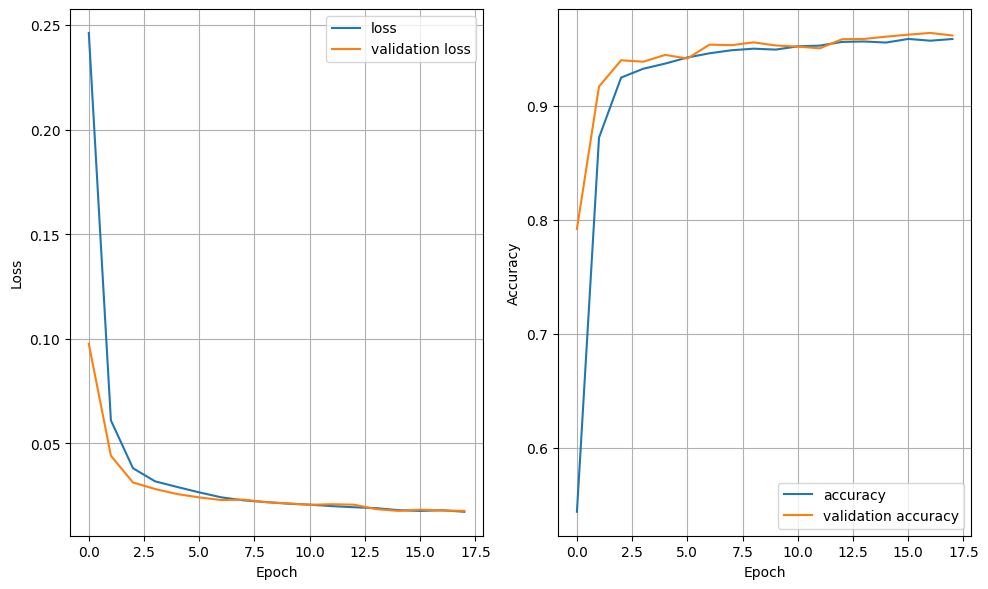

In [10]:
import matplotlib.pyplot as plt

history = np.load(f'/data01/homes/dipiano/astroAI/astroai/models/cnn_regressor/{savename}_history.npy', 
                  allow_pickle='TRUE').item()


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].plot(history['loss'], label='loss')
ax[0].plot(history['val_loss'], label = 'validation loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
#ax.set_ylim([0.2,0.65])
ax[0].grid()
ax[0].legend(loc=0)

ax[1].plot(history['accuracy'], label='accuracy')
ax[1].plot(history['val_accuracy'], label = 'validation accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
#ax.set_ylim([0.2,0.65])
ax[1].grid()
ax[1].legend(loc=0)

plt.tight_layout()
plt.show()

# Get separation error

In [11]:
from astroai.tools.utils import *
from astropy.coordinates import SkyCoord

# get true coordinates in SkyCoord
true = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')

# get errors
err = true.separation(sky)

print(f"TRUE: ({true.ra.deg}, {true.dec.deg})\n")
print(f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg})\n")
print(f"ERROR: {err.deg}")

TRUE: (340.29047888283674, 82.86751130860833)

PREDICTION: (339.9150423778824, 82.84679168174516)

ERROR: 0.05107448906261843


# Get DS separation error

In [12]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))

err_noisy = [e.degree for e in err]
len(err_noisy)

4000

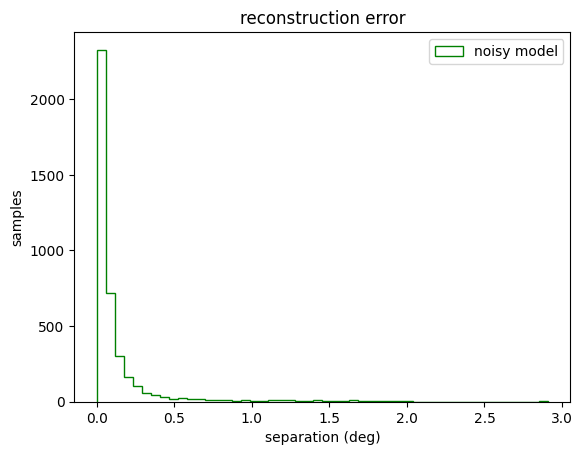

In [13]:
ax = plt.subplot()

# cumulative counts hist
data = err_noisy
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color='g', label=['noisy model'])
ax.set_ylabel('samples')
ax.set_xlabel('separation (deg)')
ax.legend()

# Compare with cleaned model

In [14]:
# dataset 
if 'CLEAN' not in dataset:
    dataset = dataset.replace('.npy', '_CLEAN.npy')
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
# split data
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, 
                                                                            binning=binning)
# load model
if 'CLEAN' not in savename:
    savename = savename + '_CLEAN'
    model = tf.keras.models.load_model(f'../models/cnn_regressor/{savename}.keras')
model.summary()

# predictions
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

(16000, 200, 200) (16000, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 6)       102       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 12)        300       
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 12)        588       
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 12)        588       
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 12)        588       
                           

(array([ 61.43467, 144.37181], dtype=float32),
 array([126.83563664, 106.7095648 ]))

In [15]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_clean = [e.degree for e in err]
len(err_clean)

4000

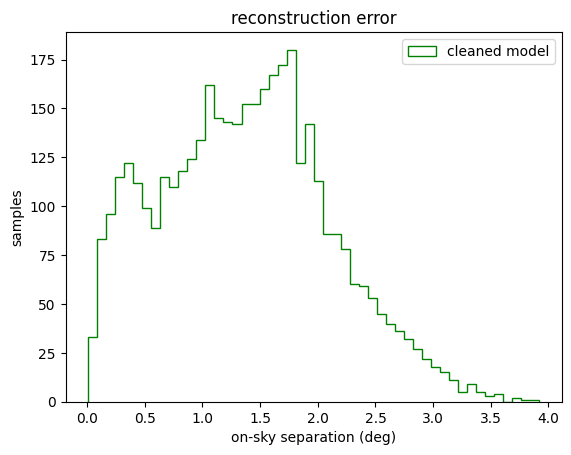

In [16]:
ax = plt.subplot()

# cumulative counts hist
data = err_clean
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color='g', label=['cleaned model'])
ax.set_ylabel('samples')
ax.set_xlabel('on-sky separation (deg)')
ax.legend()

# Comparison hist

Model yx is the one with better improvement.

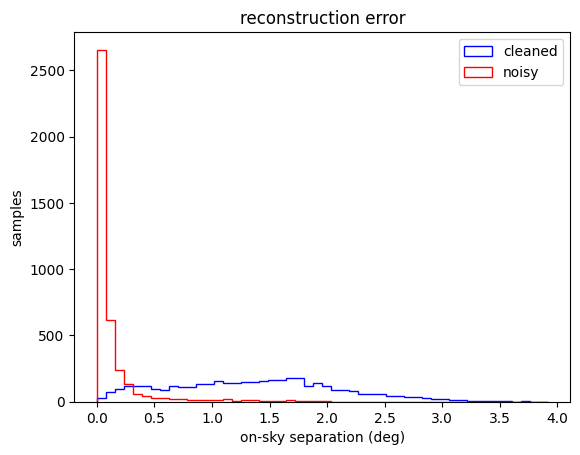

In [17]:
data = (err_noisy, err_clean)

ax = plt.subplot()
colors = ['red', 'blue'] 

# cumulative counts hist
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color=colors, label=['noisy', 'cleaned'])
ax.set_ylabel('samples')
ax.set_xlabel('on-sky separation (deg)')
#ax.set_xscale('log')
ax.legend()

# Gammapy comparison

In [18]:
gammafile = f'{path}/regressor_5sgm_exp30m_z20_xy_flip_gammapy_2000sz.txt'
gammadata = pd.read_csv(gammafile, sep=' ', header=0).sort_values(by=['seed'])
gammadata.head()

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma,correct_irf,selected_irf
0,8001,160.074066,5.495648,NaN,NaN,NaN,NaN,NaN,North_z20_S_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
1,8002,288.501191,10.680641,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
2,8003,243.508483,80.010392,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
3,8004,181.084998,73.805329,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
4,8005,237.250146,-79.382836,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...


In [19]:
err = []
seeds = gammadata['seed']
for i, seed in enumerate(seeds):
    row = infodata[infodata['seed']==seed]
    grow = gammadata[gammadata['seed']==seed]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    # found coordinates
    found_deg = {'ra': grow['loc_ra'].values[0], 'dec': grow['loc_dec'].values[0]}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_gamma = [e.degree for e in err]
len(err_noisy), len(err_gamma)

(4000, 2000)

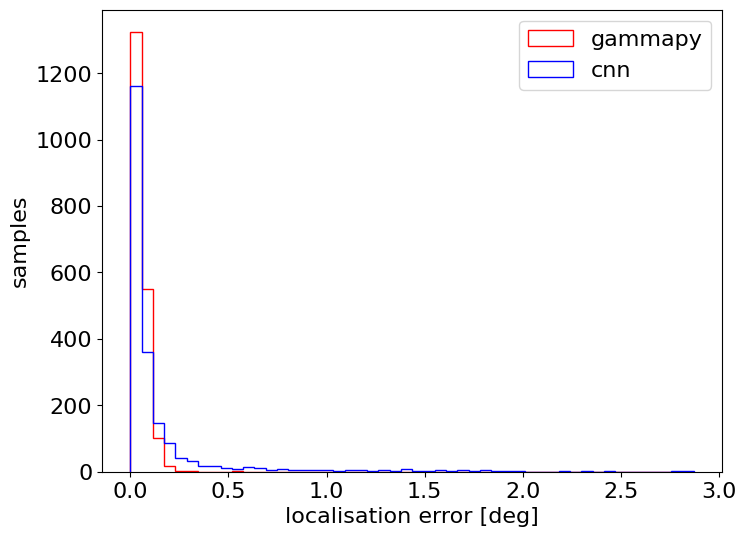

In [21]:
data = (err_noisy, err_clean, err_gamma)
data = (err_noisy[2000:], err_gamma)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot()
colors = ['blue', 'red', 'green'] 
colors = ['blue', 'red'] 
fs=16

# cumulative counts hist
#ax.set_title('reconstruction error', fontsize=fs*1.5)
#ax.hist(data, 50, density=False, histtype='step', color=colors, label=['noisy', 'cleaned', 'gamma'])
ax.hist(data, 50, density=False, histtype='step', color=colors, label=['cnn', 'gammapy'])
ax.set_ylabel('samples', fontsize=fs)
ax.set_xlabel('localisation error [deg]', fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)
#ax.set_xscale('log')
ax.legend(fontsize=fs)